# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import dotenv
import glob
import os
import pathlib
import site
import sys
import warnings
# data handling libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning libraries
import gpytorch
from sklearn import gaussian_process as gp
import torch

import pamir_mlpermafrost as pamir

In [3]:
sns.set_style('white')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [6, 3.5]

# Data exploration

Data should have been prepared with the `../../pamir-CryoGrid/` package and should be in Zarr format.  
This zarr file can live either on disk or in a cloud storage bucket. Make sure that you have a `.env` file if you're using an S3 bucket.  

## Data loading


In [15]:
experiment = 'k1500-pamir_N180-exp1'
target = 'active_layer_thickness'

In [16]:
fname_cryogrid = f'simplecache::s3://spi-pamir-cryogrid/processed-cluster_config/cluster_config-{experiment}.zarr/'
fname_spatial = f'simplecache::s3://spi-pamir-cryogrid/processed-cluster_config/spatial_variables-710w365s750e400n-100m.zarr/'
fname_training = f'{pamir.data.s3._base_path}/data/training/training_data-{target}--{experiment}.parquet'

ds_cryogrid = xr.open_zarr(fname_cryogrid, storage_options=pamir.data.s3.fsspec_kwargs)
ds_spatial = xr.open_zarr(fname_spatial, storage_options=pamir.data.s3.fsspec_kwargs)

/Users/luke/Work/PAMIR/pamir-MLpermafrost/.venv/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<fsspec.implementations.cached.SimpleCacheFileSystem object at 0x143058080>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/Users/luke/Work/PAMIR/pamir-MLpermafrost/.venv/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<fsspec.implementations.cached.SimpleCacheFileSystem object at 0x150b0edb0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


In [17]:
cluster_selectors = (
    ds_cryogrid.cluster_params
    .sel(variable=['latitude', 'longitude'])
    .to_series()
    .unstack()
    .rename(columns=dict(latitude='y', longitude='x'))
    .to_xarray())

df_spatial = ds_spatial.sel(**cluster_selectors, method='nearest').to_dataframe()

In [18]:
df_X = ds_cryogrid.cluster_params.to_series().unstack()
df_X['temperature'] = df_spatial.temperature
df_X['precipitation'] = df_spatial.precipitation

## Target: active layer thickness

In [21]:
# organise data
da_thicknesses = ds_cryogrid.ground_class_thickness.load()
da_active_layer = da_thicknesses.sel(thermal_class='active_layer')
ser_active_layer = da_active_layer.mean('time_1YS').to_series().rename(target)

df_X[target] = ser_active_layer

target_pretty = target.replace('_', ' ').title()

Text(0.5, 8.222222222222216, 'Active Layer Thickness [m]')

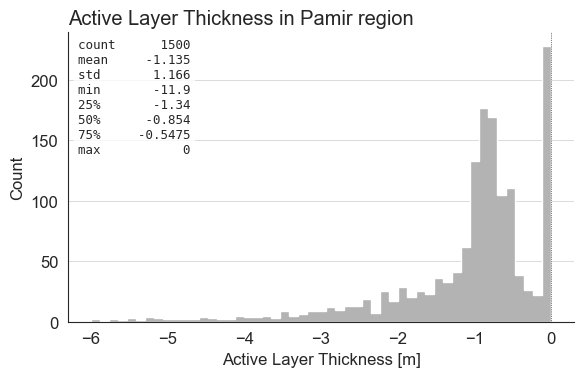

In [23]:
fig, axs = pamir.viz.stats.plot_hist_from_series(df_X[target], range=(-6, 0))
axs.set_title(f'{target_pretty} in Pamir region', loc='left')
axs.set_xlabel(f'{target_pretty} [m]')

In [25]:
vars = [
    'altitude',
    'slope_angle',
    'aspect',
    'albedo',
    'emissivity',
    'temperature',
    'precipitation',
    target,
]

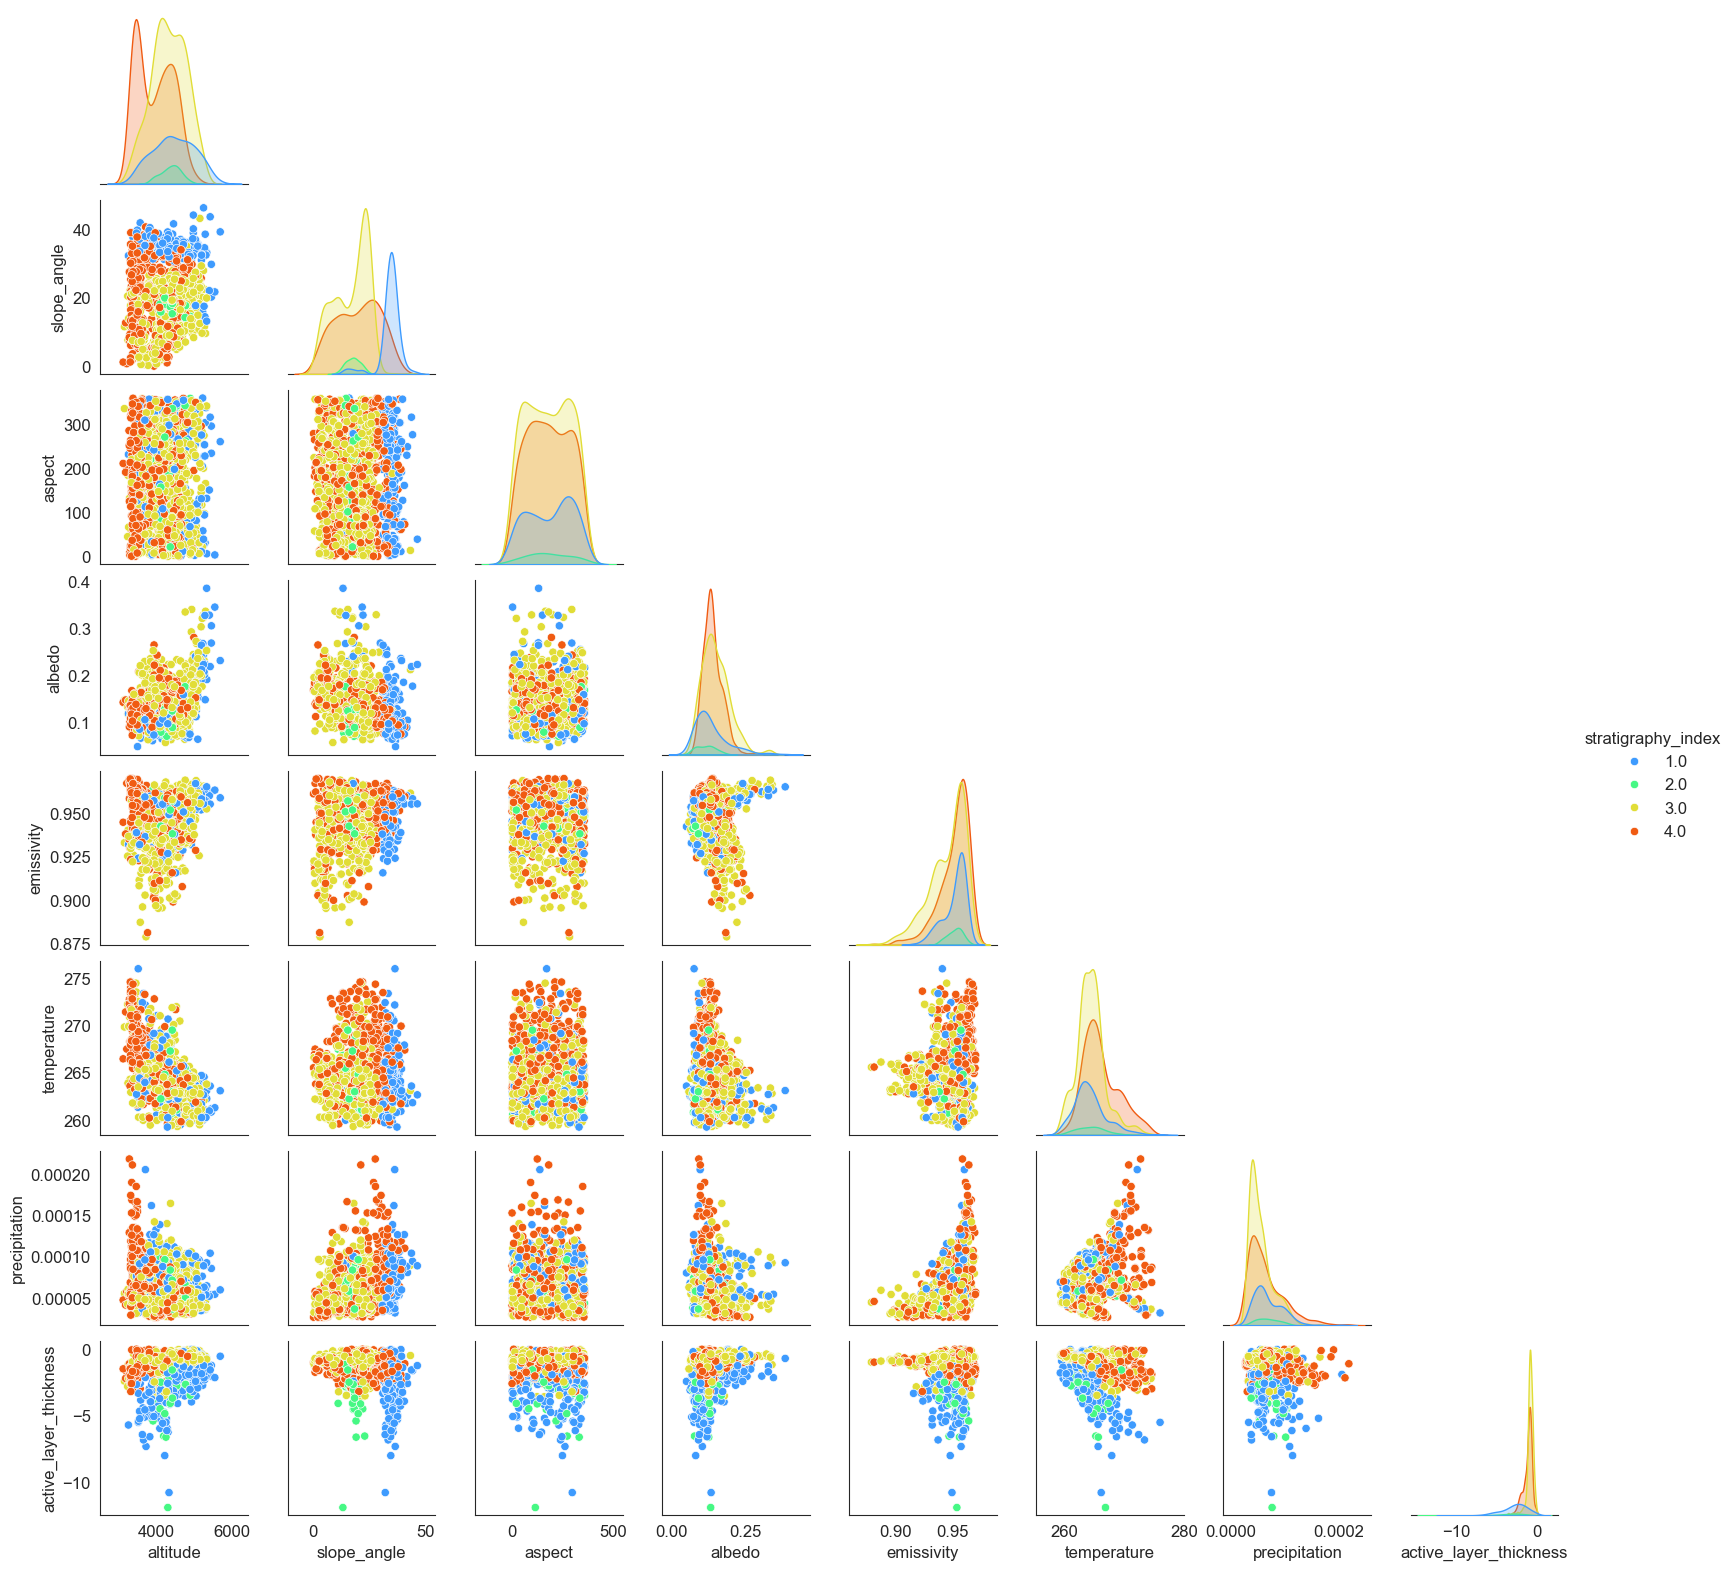

In [11]:
alt = df_X.active_layer_thickness
df_X_clipped = df_X.where((alt < 0)).dropna()

sns.pairplot(
    data=df_X_clipped, 
    vars=vars, 
    hue='stratigraphy_index', 
    palette=sns.color_palette('turbo', n_colors=4),
    corner=True,
    height=2,
)

### Changes in active layer thickness per decade

In [26]:
slopes = (
    da_active_layer
    .groupby('time_1YS.year').mean()
    .polyfit(dim='year', deg=1)
    .polyfit_coefficients
    .rename('slope')
    .pipe(lambda x: x * 10)
    .sel(degree=1, drop=True)
    .to_series())

df_X[f'{target}_slope'] = slopes

Text(0.5, 13.722222222222216, 'Active layer thickness change [m / decade]')

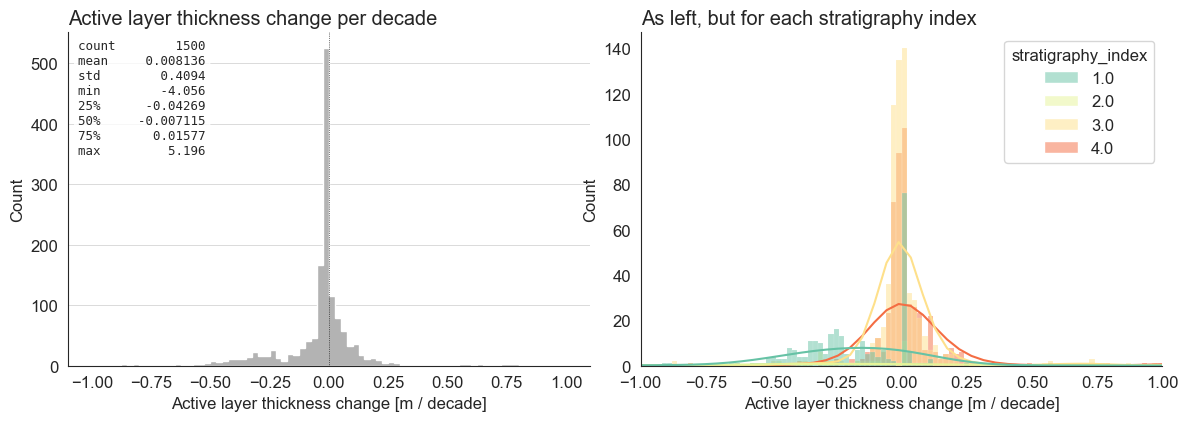

In [27]:
key = f'{target}_slope'

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax0 = pamir.viz.stats.plot_hist_from_series(df_X[key], ax=axs[0], bins=np.arange(-1, 1.01, 0.025))[1]
# ax0.set_yscale('log')
ax0.set_title('Active layer thickness change per decade', loc='left')
ax0.set_xlabel('Active layer thickness change [m / decade]')

ax1 = sns.histplot(
    data=df_X,
    x=key,
    hue='stratigraphy_index',
    binrange=(-1, 1),
    binwidth=0.02,
    palette=sns.color_palette('Spectral_r', n_colors=4),
    kde=True,)
ax1.set_xlim(-1, 1)
ax1.set_title('As left, but for each stratigraphy index', loc='left')
ax1.set_xlabel('Active layer thickness change [m / decade]')

In [29]:
df_X.to_parquet(fname_training)